# Import Libraries

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
# solver = 'appsi_highs'
solver = 'mosek_direct'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Analysis

In [2]:
file_path = 'Data.xlsx'
data = pd.read_excel(file_path, index_col=0)
data.dropna(how='all', axis=1, inplace=True)  
data

,2023,2022,2021,2020,2019,2018,2017,2016
enrollment,,,,,,,,
115,117.0,83.0,100.0,93.0,73.0,68.0,66.0,63.0
120,137.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,64.0,52.0,53.0,48.0,35.0,45.0,40.0,31.0
142A,202.0,200.0,204.0,NaN,148.0,92.0,59.0,NaN
145,10.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
150,NaN,NaN,NaN,26.0,22.0,30.0,NaN,42.0
160,78.0,90.0,86.0,102.0,100.0,69.0,80.0,97.0
162,79.0,70.0,56.0,79.0,90.0,77.0,82.0,86.0
171,27.0,NaN,NaN,40.0,56.0,53.0,44.0,93.0


# Construct the Model 

In [3]:
def class_scheduling(I, J, K, e, c, J2, J3, P1, P2, P3, P4, P5, D):
    model = pyo.ConcreteModel()
    
    model.I = pyo.RangeSet(1, I)  # time period
    model.J = pyo.RangeSet(1, J)  # course
    model.K = pyo.RangeSet(1, K)  # classroom
    model.J2 = pyo.Set(initialize=J2)
    model.J3 = pyo.Set(initialize=J3)
    
    def dist_init(model, k, l):
        return D[k-1, l-1]
    model.D = pyo.Param(model.K, model.K, initialize=dist_init)
    
    # decision variables
    model.x = pyo.Var(model.I, model.J, model.K, within=pyo.Binary)
    model.y = pyo.Var(model.I, model.J, within=pyo.Binary)
    model.z = pyo.Var(model.J, model.K, within=pyo.Binary)
    # penalties
    model.p1 = pyo.Var(model.I, within=pyo.NonNegativeIntegers)
    model.p2 = pyo.Var(within=pyo.NonNegativeIntegers)
    model.d = pyo.Var(pyo.RangeSet(1, 39), model.K, model.K, within=pyo.Binary)


    
    def schedule_penalty(model):
        penalty = 0
        for i in pyo.RangeSet(21, 40):
            for j in model.J2:
                for k in model.K:
                    penalty += model.x[i, j, k] * P4
        for i in pyo.RangeSet(1, 20):
            for j in model.J3:
                for k in model.K:
                    penalty += model.x[i, j, k] * P5
        return penalty
    
    def distance_penalty(model):
        return sum(model.D[k, l] * model.d[i, k, l] for k in model.K for l in model.K for i in pyo.RangeSet(1, 39))

    # objective function
    model.cost = pyo.Objective(expr=sum(c[k-1] * model.x[i, j, k] for i in model.I for j in model.J for k in model.K)
                               + P1 * sum(model.p1[i] for i in model.I) + P2 * model.p2 
                               + schedule_penalty(model)+ P3 * distance_penalty(model), sense=pyo.minimize)
    
    # constraints
    model.C1 = pyo.ConstraintList()
    for j in model.J:
        for k in model.K:
            model.C1.add(model.x[20, j, k] == 0)
            model.C1.add(model.y[20, j] == 0)
            model.C1.add(model.x[40, j, k] == 0)
            model.C1.add(model.y[40, j] == 0)
    for j in model.J3:
        for k in model.K:
            model.C1.add(model.x[19, j, k] == 0)
            model.C1.add(model.y[19, j] == 0)
            model.C1.add(model.x[39, j, k] == 0)
            model.C1.add(model.y[39, j] == 0)
    model.C2 = pyo.Constraint(model.J, rule=lambda model, j: sum(model.y[i, j] for i in model.I) == 1)
    for j in model.J2:
        model.C1.add(sum(model.x[i, j, k] for i in model.I for k in model.K) == 2)
    for j in model.J3:
        model.C1.add(sum(model.x[i, j, k] for i in model.I for k in model.K) == 3)
    model.Constraint1 = pyo.Constraint(pyo.RangeSet(1, 39), model.J,  
                                       rule=lambda model, i, j: model.y[i, j] <= sum(model.x[i, j, k] for k in model.K))
    model.Constraint2 = pyo.Constraint(pyo.RangeSet(1, 39), model.J, 
                                       rule=lambda model, i, j: model.y[i, j] <= sum(model.x[i+1, j, k] for k in model.K))
    model.Constraint3 = pyo.Constraint(pyo.RangeSet(1, 38), model.J3, 
                                       rule=lambda model, i, j: model.y[i, j] <= sum(model.x[i+2, j, k] for k in model.K))
    model.ClassroomAssignmentConstraint = pyo.Constraint(model.I, model.J, model.K, 
                                                 rule=lambda model, i, j, k: model.x[i, j, k] <= model.z[j, k])
    model.SingleClassroomUsage = pyo.Constraint(model.J, 
                                            rule=lambda model, j: sum(model.z[j, k] for k in model.K) == 1)
    model.ClassroomLimit = pyo.Constraint(model.I, model.K, rule=lambda model, i, k: sum(model.x[i, j, k] for j in model.J) <= 1)
    model.CapacityLimit = pyo.Constraint(model.I, model.J, model.K, rule=lambda model, i, j, k: e[j-1] * model.x[i, j, k] <= c[k-1])
    model.ConflictConstraint = pyo.Constraint(model.I, 
                                              rule=lambda model, i: sum(model.x[i, j, k] for j in model.J for k in model.K) <= 1 + model.p1[i])
    model.SpecialTimeConstraint = pyo.Constraint(rule=lambda model: sum(model.y[1, j] + model.y[2, j] + model.y[21, j] + model.y[22, j] 
                                                                    for j in model.J) <= model.p2)
    for i in model.I:
        if i < max(model.I): 
            for k in model.K:
                for l in model.K:
                    model.C1.add(model.d[i, k, l] <= sum(model.x[i, j, k] for j in model.J))
                    model.C1.add(model.d[i, k, l] <= sum(model.x[i+1, j, l] for j in model.J))
                    model.C1.add(1+model.d[i, k, l] >= sum(model.x[i, j, k] for j in model.J) + sum(model.x[i+1, j, l] for j in model.J))
    

    return model


# Solve the Model

In [4]:
I = 40  
J = 11 
K = 5  
P1 = 1000
P2 = 200
P3 = 50
P4 = P5 = 10
J2 = [1, 2, 5, 7, 8, 11]
J3 = [3, 4, 6, 9, 10]
e = [100, 115, 45, 195, 30, 45, 85, 85, 45, 120, 120]
c = [45, 45, 292, 158, 132]
D = np.array([
    [0, 0, 0.35, 0.55, 0.11],
    [0, 0, 0.35, 0.55, 0.11],
    [0.35, 0.35, 0, 0.6, 0.28],
    [0.55, 0.55, 0.6, 0, 0.7],
    [0.11, 0.11, 0.28, 0.7, 0]
])
model = class_scheduling(I, J, K, e, c, J2, J3, P1, P2, P3, P4, P5, D)
result = SOLVER.solve(model)

# Result Visualization

In [5]:
j_names = ['IEOR 115', 'IEOR 120', 'IEOR 130', 
           'IEOR 142A', 'IEOR 145', 'IEOR 150', 
           'IEOR 160', 'IEOR 162', 'IEOR 171', 
           'IEOR 172', 'IEOR 174'] 
k_names = ['ETCH 1174', 'ETCH 3107', 'STAN 105', 'VLSB 2040', 'CORY 277']
print("Optimal Cost:", model.cost())

Optimal Cost: 3092.499999999998


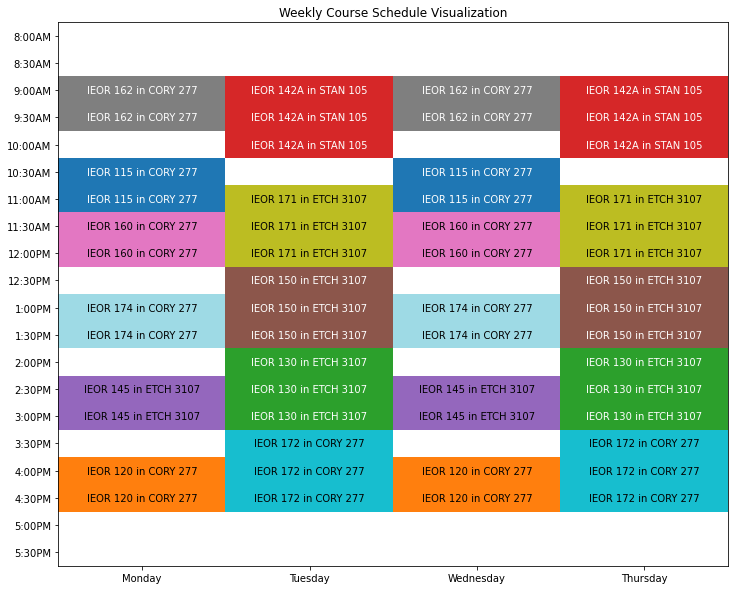

In [6]:
time_labels = [f"{hour % 12 if hour % 12 != 0 else 12}:{minute:02d}{'AM' if hour < 12 else 'PM'}" 
               for hour in range(8, 18) for minute in (0, 30)]
schedule = pd.DataFrame(index=pd.Index(time_labels, name='Time'), columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday'])

for j in model.J:
    for i in model.I:
        if i <= 20:
            days = ['Monday', 'Wednesday']
        else:  
            days = ['Tuesday', 'Thursday']
        time_label = time_labels[(i - 1) % 20]
        for k in model.K:
            if round(model.x[i, j, k].value) == 1:
                entry = f"{j_names[j-1]} in {k_names[k-1]}"
                for day in days:
                    if pd.isna(schedule.at[time_label, day]):
                        schedule.at[time_label, day] = entry
                    else:
                        schedule.at[time_label, day] += "; " + entry
schedule = schedule.fillna('')

colors = plt.cm.get_cmap('tab20', len(j_names))
course_color_map = {course: colors(i) for i, course in enumerate(j_names)}
num_color_matrix = np.zeros((schedule.shape[0], schedule.shape[1], 4))

for i, (idx, row) in enumerate(schedule.iterrows()):
    for j, value in enumerate(row):
        if value:
            course_name = value.split(' in ')[0]
            if course_name in course_color_map:
                num_color_matrix[i, j, :] = course_color_map[course_name]

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(num_color_matrix, aspect='auto')

for i in range(len(schedule.index)):
    for j in range(len(schedule.columns)):
        text = schedule.iloc[i, j]
        if text:
            text_color = 'white' if np.mean(num_color_matrix[i, j][:3]) < 0.5 else 'black'
            ax.text(j, i, text, ha='center', va='center', color=text_color)

ax.set_xticks(np.arange(len(schedule.columns)))
ax.set_yticks(np.arange(len(schedule.index)))
ax.set_xticklabels(schedule.columns)
ax.set_yticklabels(schedule.index)
ax.set_title('Weekly Course Schedule Visualization')
plt.show()
